<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fit-and-plot-neutralization-curves" data-toc-modified-id="Fit-and-plot-neutralization-curves-1">Fit and plot neutralization curves</a></span><ul class="toc-item"><li><span><a href="#Import-Python-modules-/-packages" data-toc-modified-id="Import-Python-modules-/-packages-1.1">Import Python modules / packages</a></span></li><li><span><a href="#Configuration-and-setup" data-toc-modified-id="Configuration-and-setup-1.2">Configuration and setup</a></span></li><li><span><a href="#Read-neutralization-data" data-toc-modified-id="Read-neutralization-data-1.3">Read neutralization data</a></span></li><li><span><a href="#Fit-and-plot-all-neutralization-curves" data-toc-modified-id="Fit-and-plot-all-neutralization-curves-1.4">Fit and plot all neutralization curves</a></span></li><li><span><a href="#Neutralization-curves-integrated-with-logo-plots" data-toc-modified-id="Neutralization-curves-integrated-with-logo-plots-1.5">Neutralization curves integrated with logo plots</a></span></li></ul></li></ul></div>

# Fit and plot neutralization curves
In this notebook we will plot neutralization curves from GFP-based neutralization assays. 
The GFP-based neutralization assay system is described in detail [here](https://github.com/jbloomlab/flu_PB1flank-GFP_neut_assay).

All the curves plotted here represent the mean and standard deviation of three replicates, with each replicate in a separate column of a 96-well plate.

The curves fit are the Hill-style neutralization functions fit and plotted by the [neutcurve](https://jbloomlab.github.io/neutcurve/) package.

## Import Python modules / packages
In addition to importing the [neutcurve](https://jbloomlab.github.io/neutcurve/) package, we import [svgutils](https://svgutils.readthedocs.io) to merge the neutralization curves with the logo plots, and [cairosvg](https://cairosvg.org/) to convert SVGs to other formats:

In [1]:
import collections
import itertools
import os
import re
import warnings
import xml.etree.ElementTree as ElementTree

import cairosvg

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import numpy

import pandas as pd

import svgutils.compose

import yaml

from dms_tools2.ipython_utils import showPDF

import neutcurve
from neutcurve.colorschemes import CBPALETTE
import neutcurve.parse_excel

print(f"Using neutcurve version {neutcurve.__version__}")

Using neutcurve version 0.2.4


Interactive matplotlib plotting:

In [2]:
plt.ion()

Suppress warnings that can clutter output:

In [3]:
warnings.simplefilter('ignore')

## Configuration and setup
Read general configuration from [config.yaml](config.yaml), which in turn specifies additional configuration files:

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Read the neutralization assay configuration from the specified file:

In [5]:
print(f"Reading neutralization assay setup from {config['neut_config']}")

with open(config['neut_config']) as f:
    neut_config = yaml.safe_load(f)

Reading neutralization assay setup from data/neut_assays/neut_config.yaml


Get the output directory:

In [6]:
outdir = config['neutresultsdir']
os.makedirs(outdir, exist_ok=True)
print(f"Output will be written to {outdir}")

Output will be written to results/neutralization_assays


## Read neutralization data

Next, for each dict in *neut_config*, we use [neutcurve.parse_excel.parseRachelStyle2019](https://jbloomlab.github.io/neutcurve/neutcurve.parse_excel.html#neutcurve.parse_excel.parseRachelStyle2019) to parse the raw Excel files to create a tidy data frame appropriate for passing to [neutcurve.CurveFits](https://jbloomlab.github.io/neutcurve/neutcurve.curvefits.html#neutcurve.curvefits.CurveFits). 
We then concatenate all the tidy data frames to get our neutralization data.
This is essentially the workflow [explained here](https://jbloomlab.github.io/neutcurve/rachelstyle2019_example.html):

In [7]:
neutdata = []  # store all data frame, then concatenate at end

for sampledict in neut_config:
    assert len(sampledict) == 1
    sampleset, kwargs = list(sampledict.items())[0]
    print(f"Parsing data for {sampleset}...")
    neutdata.append(neutcurve.parse_excel.parseRachelStyle2019(**kwargs))

neutdata = pd.concat(neutdata)
print(f"Read data for {len(neutdata.groupby('serum'))} sera and "
      f"{len(neutdata.groupby(['serum', 'virus']))} serum / virus pairs.")

Parsing data for VIDD1...
Parsing data for VIDD2...
Parsing data for VIDD3...
Parsing data for VIDD4...
Parsing data for VIDD5...
Parsing data for 557v1...
Parsing data for 557v2...
Parsing data for 574v1...
Parsing data for 574v2...
Parsing data for 589v1...
Parsing data for 589v2...
Parsing data for 571v1...
Parsing data for 571v2...
Parsing data for ferret-Pitt-1-preinf...
Parsing data for ferret-Pitt-1-postinf...
Parsing data for ferret-Pitt-2-preinf...
Parsing data for ferret-Pitt-2-postinf...
Parsing data for ferret-Pitt-3-preinf...
Parsing data for ferret-Pitt-3-postinf...
Parsing data for ferret-WHO...
Parsing data for ferret-WHO-Victoria2011...
Parsing data for antibody-5A01...
Parsing data for antibody-3C06...
Parsing data for antibody-3C04...
Parsing data for antibody-4C01...
Parsing data for antibody-4F03...
Parsing data for antibody-1C04...
Read data for 27 sera and 119 serum / virus pairs.


These data look like this:

In [8]:
display(HTML(neutdata.head().to_html(index=False)))

serum,virus,replicate,concentration,fraction infectivity
2010-age-21,wt,1,0.000024,1.010575
2010-age-21,wt,1,0.000046,0.981598
2010-age-21,wt,1,0.000086,0.997023
2010-age-21,wt,1,0.000163,0.954407
2010-age-21,wt,1,0.000308,1.005039


Write the neutralization data to a CSV file in our output directory:

In [9]:
neutdatafile = os.path.join(outdir, 'neutdata.csv')
neutdata.to_csv(neutdatafile, index=False)
print(f"Wrote neutralization data to {neutdatafile}")

Wrote neutralization data to results/neutralization_assays/neutdata.csv


## Fit and plot all neutralization curves

Now we fit the neutralization curves with a neutcurve.CurveFits:

In [10]:
fits = neutcurve.CurveFits(neutdata)

Make a big panel of plots of the across-replicate averages for all sera and antibodies:


Plotting all sera curves to results/neutralization_assays/all_sera_plots.pdf...


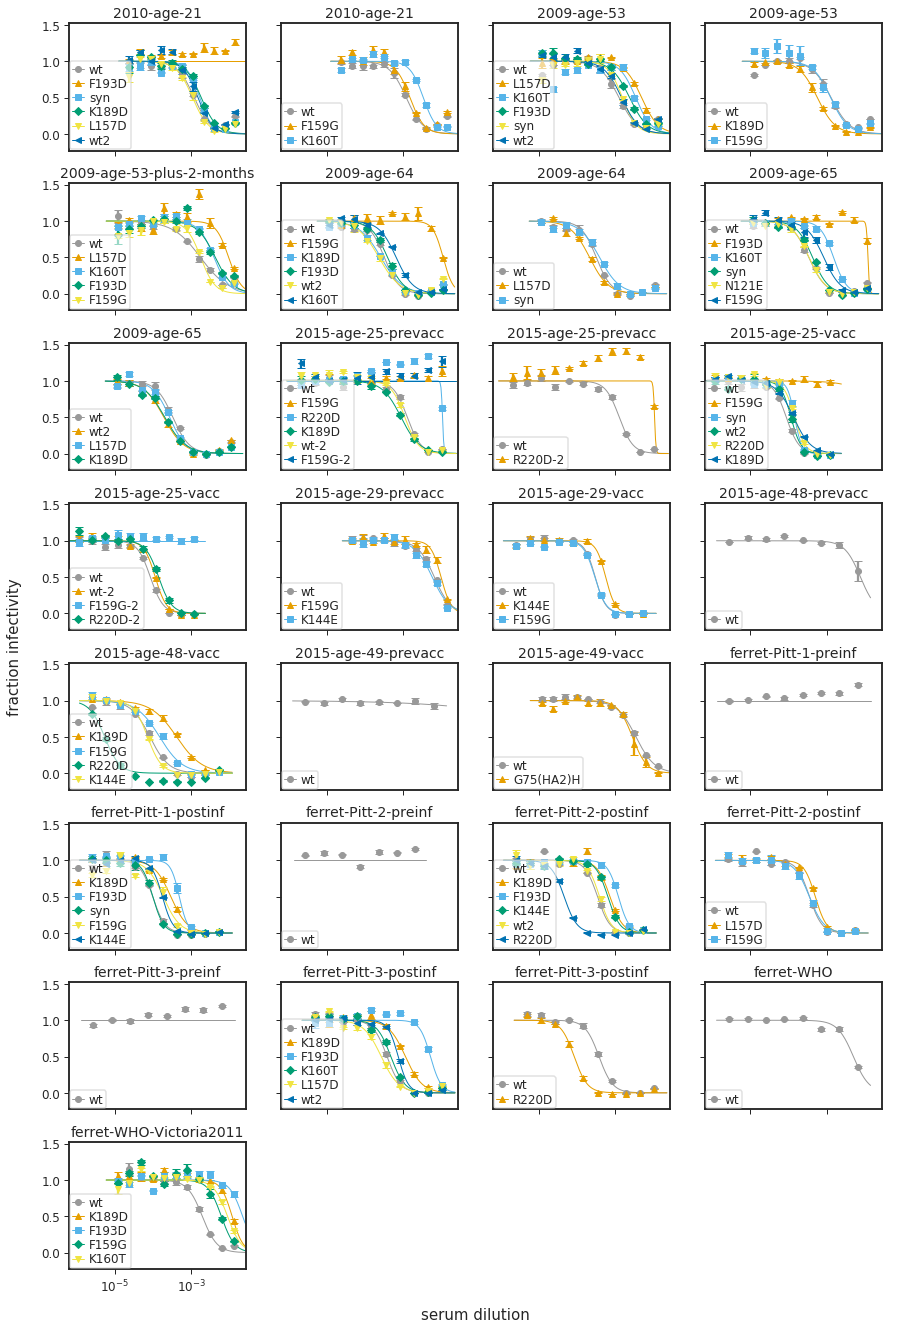


Plotting all antibody curves to results/neutralization_assays/all_antibody_plots.pdf...


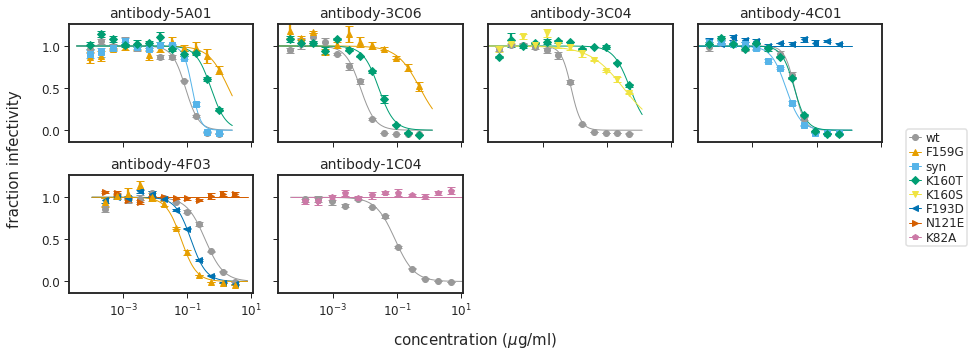

In [11]:
for is_antibody, ptype, xlabel in [(False, 'sera', 'serum dilution'),
                                   (True, 'antibody', 'concentration ($\mu$g/ml)')]:
    plotfile = os.path.join(outdir, f"all_{ptype}_plots.pdf")
    print(f"\nPlotting all {ptype} curves to {plotfile}...")
    fig, _ = fits.plotSera(
                sera=[s for s in fits.sera if ('antibody' in s) == is_antibody],
                xlabel=xlabel,
                max_viruses_per_subplot=6,
                )
    display(fig)
    fig.savefig(plotfile)
    plt.close(fig)

Now get the curve fit parameters (e.g., IC50s):

In [12]:
fitparams = fits.fitParams()

Here is a list of all of the IC50s for the replicate-averages for each serum / virus pair.
Note that for sera there are dilutions, and for antibodies that are $\mu$g/ml:

In [13]:
display(HTML(fitparams
             .query('replicate == "average"')
             .drop(columns=['midpoint', 'top', 'bottom', 'replicate',
                            'ic50', 'ic50_bound', 'slope', 'nreplicates'])
             .to_html(index=False)
             ))

serum,virus,ic50_str
2010-age-21,wt,0.00118
2010-age-21,F193D,>0.014
2010-age-21,syn,0.00164
2010-age-21,K189D,0.0018
2010-age-21,L157D,0.00107
2010-age-21,wt2,0.00148
2010-age-21,F159G,0.00148
2010-age-21,K160T,0.00329
2009-age-53,wt,0.00124
2009-age-53,L157D,0.00481


Write all of the fit parameters (including IC50s) for all replicates to a file:

In [14]:
fitfile = os.path.join(outdir, 'fitparams.csv')
print(f"Writing fit parameters to {fitfile}")
fitparams.to_csv(fitfile, index=False, float_format='%.3g')

Writing fit parameters to results/neutralization_assays/fitparams.csv


## Neutralization curves integrated with logo plots
Now we are going to make versions of the neutralization curves that are combined with the logo plots created by [analyze_map.ipynb](analyze_map.ipynb) to serve as figures.

Get the colors that we have specified for viruses in each serum group for these figures:

In [15]:
with open(config['figure_config']) as f:
    figure_config = yaml.safe_load(f)

Get data frame with all sera for each figure:

In [16]:
sera_df = pd.concat(
           [pd.DataFrame({'figure': figure,
                          'sera': figure_d['sera']})
            for figure, figure_d in figure_config['figures'].items()
            ],
           ignore_index=True
           )

Now draw the plots as single-column figures that can be aligned with the logo plots and save them as SVGs:

In [17]:
sera_viruses_plotted = [] # list 2-tuples of serum / viruses plotted
neutsvgfiles = []
for figure, df in sera_df.groupby('figure'):
    
    ifigconfig = figure_config['figures'][figure]
    colors = ifigconfig['colors']
    sera = [s for s in df['sera'].unique() if s in fits.sera]
    xlabel = ['concentration ($\mu$g/ml)' if 'antibody' in s else 'serum dilution' for s in sera]
    
    # do we have one or multiple x-axis labels, which determines whether we try to align to logos
    if len(set(xlabel)) == 1:
        xlabel = xlabel[0]
        align_to_dmslogo_facet={'height_per_ax': 2.5,
                                'hspace': 0.8,
                                'tmargin': 0.4,
                                'bmargin': 1.3,
                                'right': 0.75,
                                'left': 0.2,
                                }
        heightscale = 1
        widthscale = 1.37
        sharex = True
    else:
        align_to_dmslogo_facet = False
        heightscale = 1.23
        widthscale = 1.1
        sharex = False
    
    viruses = list(colors.keys())
    ignore_serum_virus = (ifigconfig['ignore_serum_virus'] if
                          'ignore_serum_virus' in ifigconfig else None)
    sera_viruses_plotted += [(s, v) for s, v in itertools.product(sera, viruses)
                             if not ignore_serum_virus or
                             s not in ignore_serum_virus or
                             v not in ignore_serum_virus[s]]
    
    fig, _ = fits.plotSera(
                sera=sera,
                viruses=viruses,
                ignore_serum_virus=ignore_serum_virus,
                titles=[ifigconfig['sera_names'][s] for s in sera] if 'sera_names' in ifigconfig
                        else [s.replace('-', ' ') for s in sera],
                virus_to_color_marker=colors,
                xlabel=xlabel,
                max_viruses_per_subplot=len(colors),
                ncol=1,
                titlesize=17,
                labelsize=17,
                legendfontsize=14,
                ticksize=12,
                widthscale=widthscale,
                heightscale=heightscale,
                markersize=7,
                align_to_dmslogo_facet=align_to_dmslogo_facet,
                despine=True,
                yticklocs=[0, 0.5, 1],
                sharex=sharex,
                )
    
    neutsvgfile = os.path.join(config['figsdir'], f"{figure}_neut.svg")
    print(f"Saving plot for {figure} to {neutsvgfile}")
    if sharex:
        fig.savefig(neutsvgfile)
    else:
        fig.savefig(neutsvgfile, bbox_inches='tight')
    plt.close(fig)
    neutsvgfiles.append(neutsvgfile)

Saving plot for 2009_age_53_samples to results/figures/2009_age_53_samples_neut.svg
Saving plot for Hensley_sera to results/figures/Hensley_sera_neut.svg
Saving plot for VIDD_sera to results/figures/VIDD_sera_neut.svg
Saving plot for antibody_lower_head to results/figures/antibody_lower_head_neut.svg
Saving plot for antibody_region_B to results/figures/antibody_region_B_neut.svg
Saving plot for antibody_spikein to results/figures/antibody_spikein_neut.svg
Saving plot for ferret to results/figures/ferret_neut.svg


Now we will combine the logo and SVG files. 

First, we need to define a function to get the width / height of a SVG file in points (see [here](http://osgeo-org.1560.x6.nabble.com/Get-size-of-SVG-in-Python-td5273032.html)):

In [18]:
def svg_dim(svgfile, dim):
    """Get width or height `dim` of `svgfile` in points."""
    return float(ElementTree.parse(svgfile).getroot().attrib[dim].replace('pt', ''))

We also define a function that converts a SVG into a PDF or PNG:

In [19]:
def svg_to_pdf(svgfile):
    """`svgfile` to PDF, return converted file name."""
    with open(svgfile) as f:
        svg = f.read()
    # need to eliminate units that `svgutils` incorrectly puts in viewBox
    viewbox_match = re.compile('viewBox="' + ' '.join(['\d+\.{0,1}\d*(px){0,1}'] * 4) + '"')
    if len(viewbox_match.findall(svg)) != 1:
        raise ValueError(f"did not find exactly one viewBox in {svgfile}")
    viewbox = viewbox_match.search(svg).group(0)
    svg = svg.replace(viewbox, viewbox.replace('px', ''))
    outfile = os.path.splitext(svgfile)[0] + '.pdf'
    cairosvg.svg2pdf(bytestring=svg, write_to=outfile)
    return outfile

Now we combine the neutralization curve SVGs with the logo-plot SVGs (which should already exist as output of [analyze_map.ipynb](analyze_map.ipynb)) as [here](https://svgutils.readthedocs.io/en/latest/tutorials/composing_multipanel_figures.html):


Writing figure to results/figures/2009_age_53_samples_logo_and_neut.svg and results/figures/2009_age_53_samples_logo_and_neut.pdf


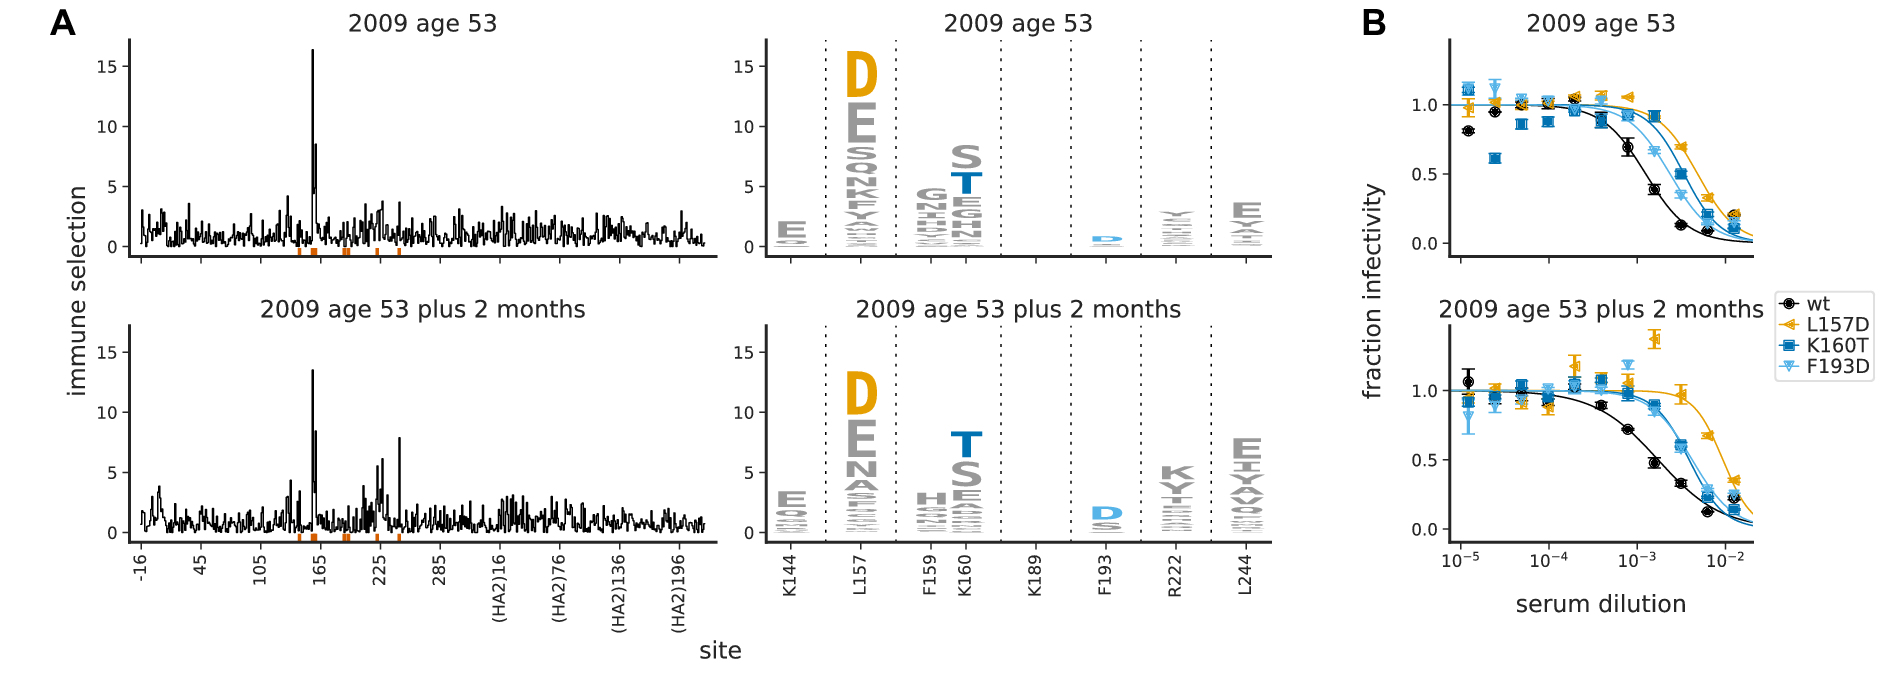


Writing figure to results/figures/Hensley_sera_logo_and_neut.svg and results/figures/Hensley_sera_logo_and_neut.pdf


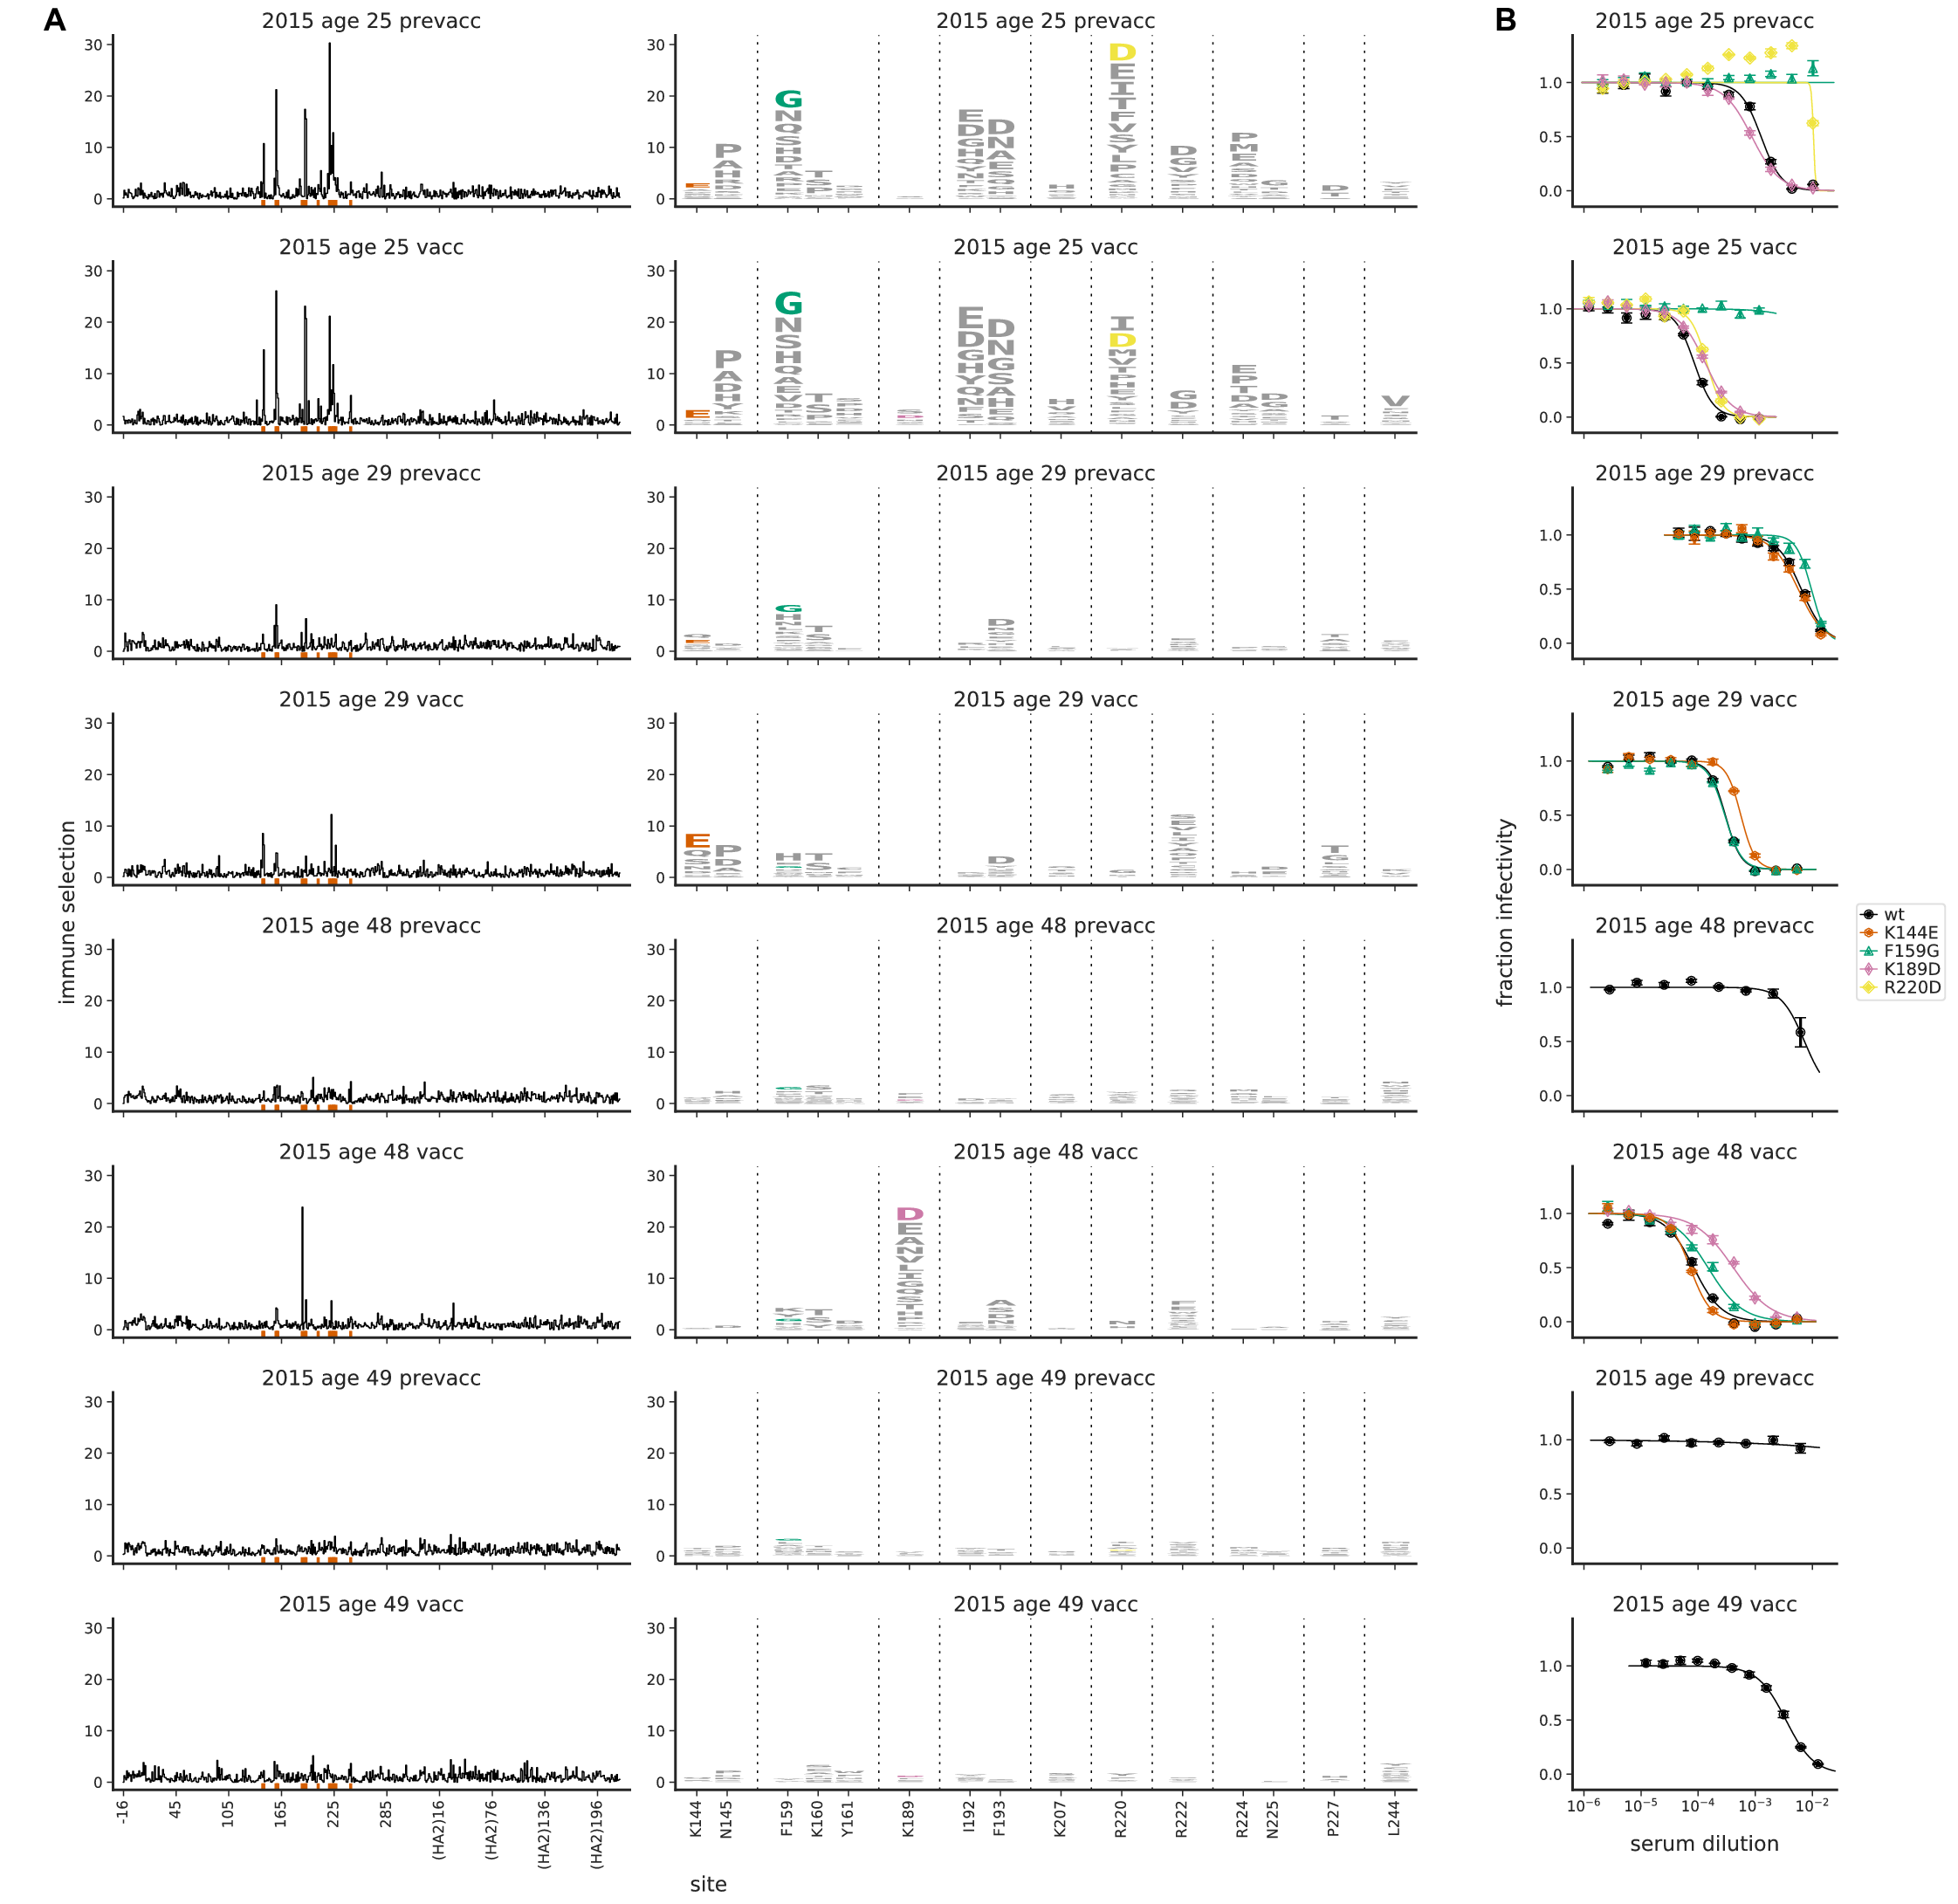


Writing figure to results/figures/VIDD_sera_logo_and_neut.svg and results/figures/VIDD_sera_logo_and_neut.pdf


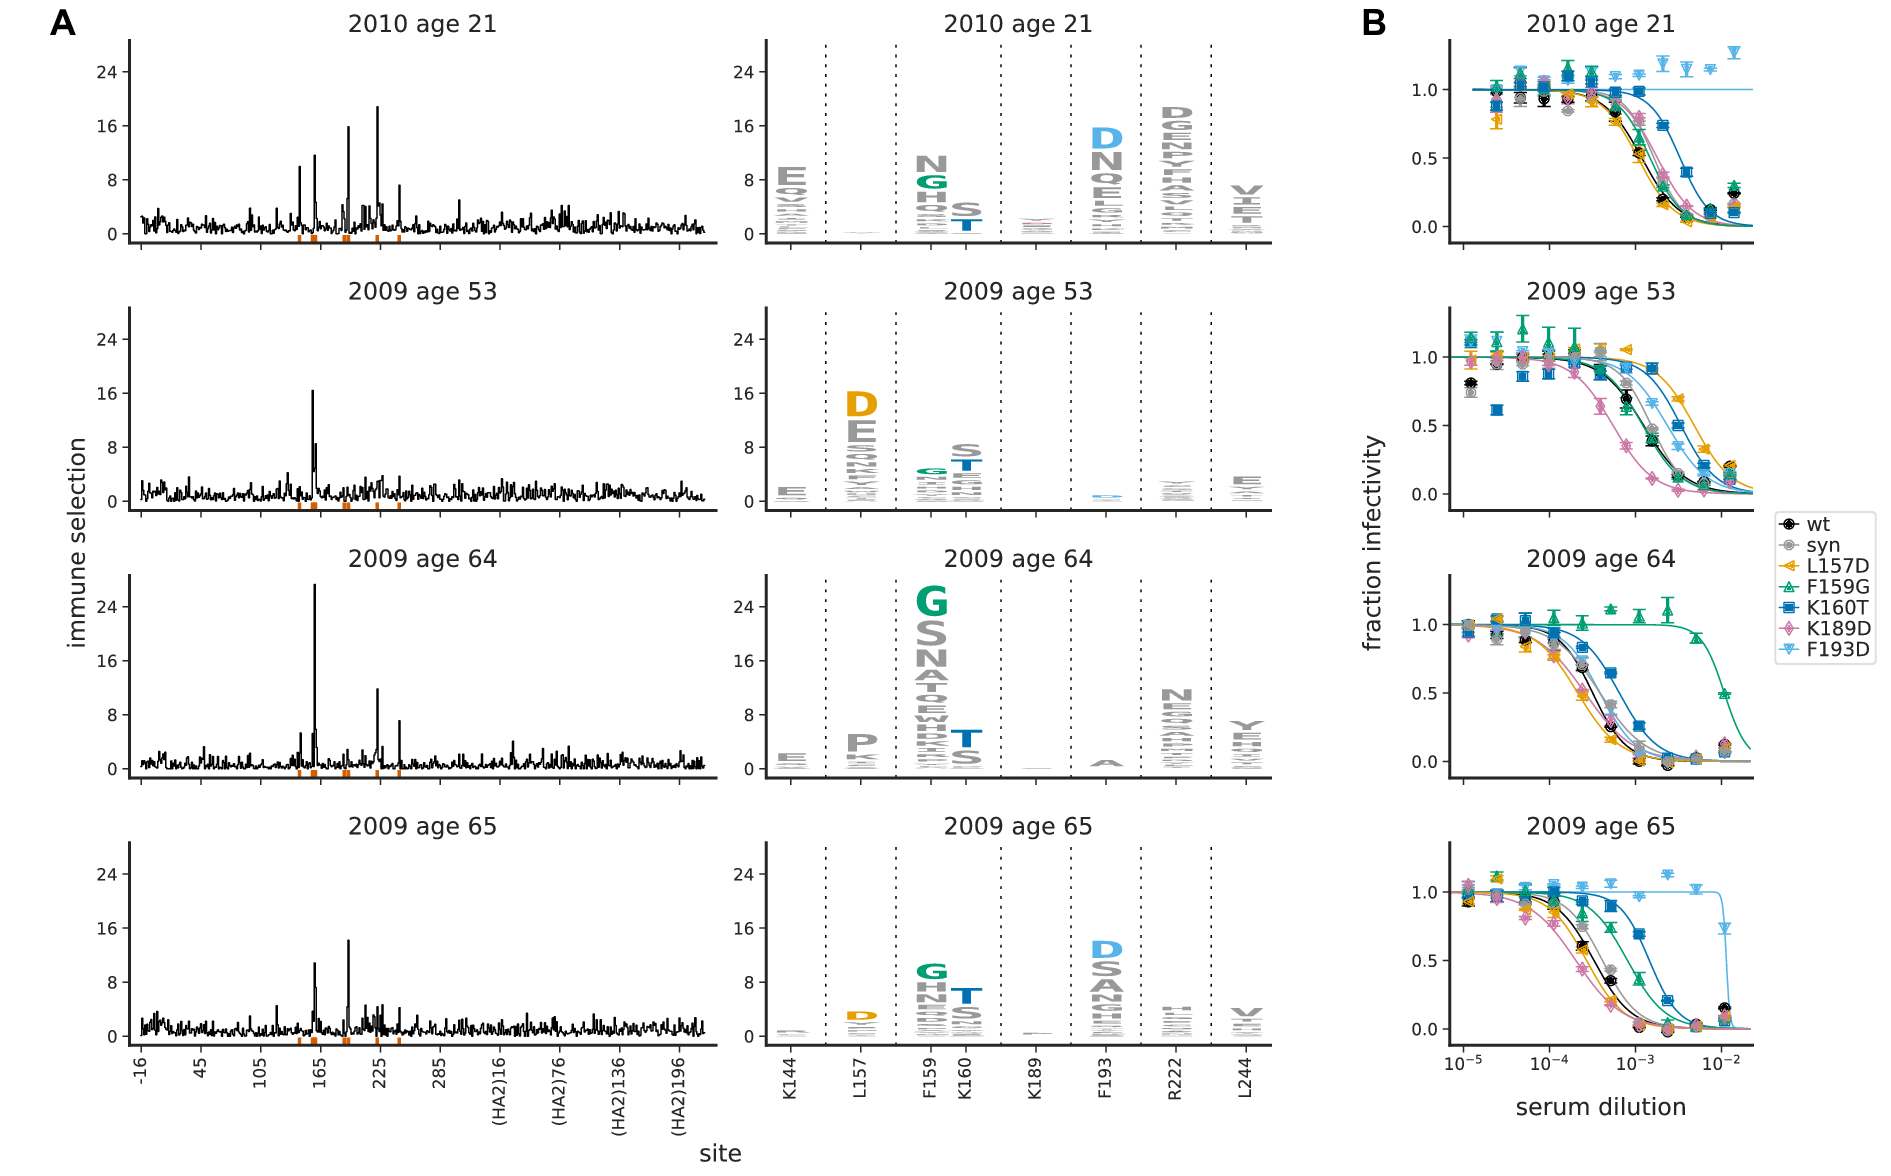


Writing figure to results/figures/antibody_lower_head_logo_and_neut.svg and results/figures/antibody_lower_head_logo_and_neut.pdf


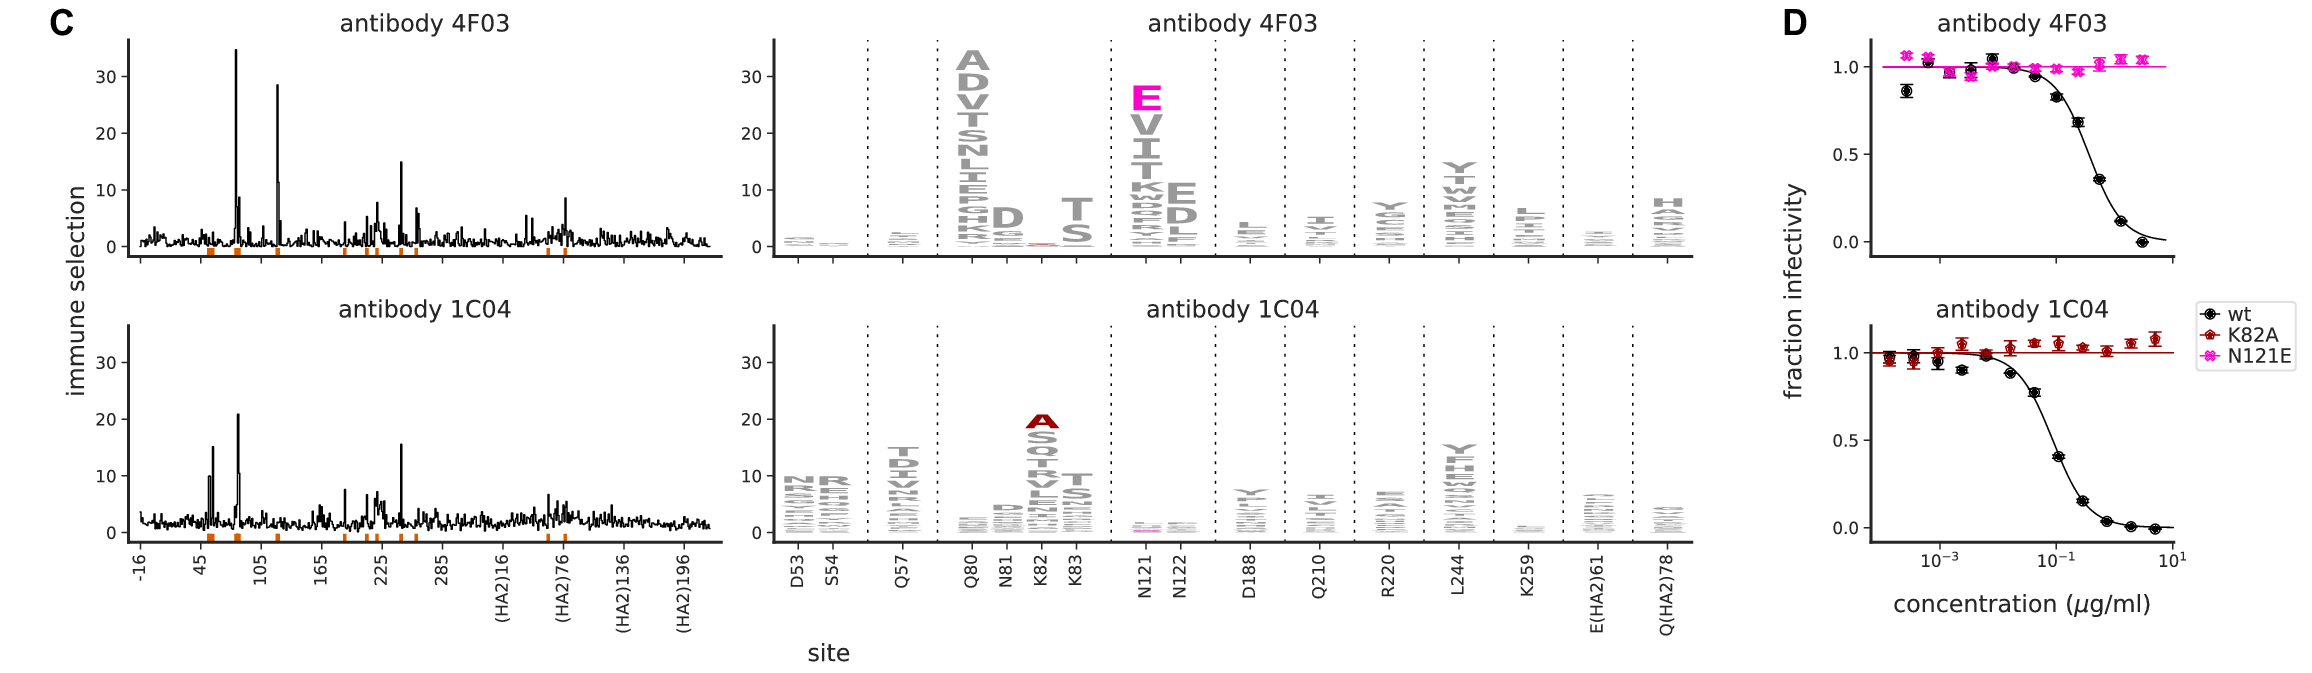


Writing figure to results/figures/antibody_region_B_logo_and_neut.svg and results/figures/antibody_region_B_logo_and_neut.pdf


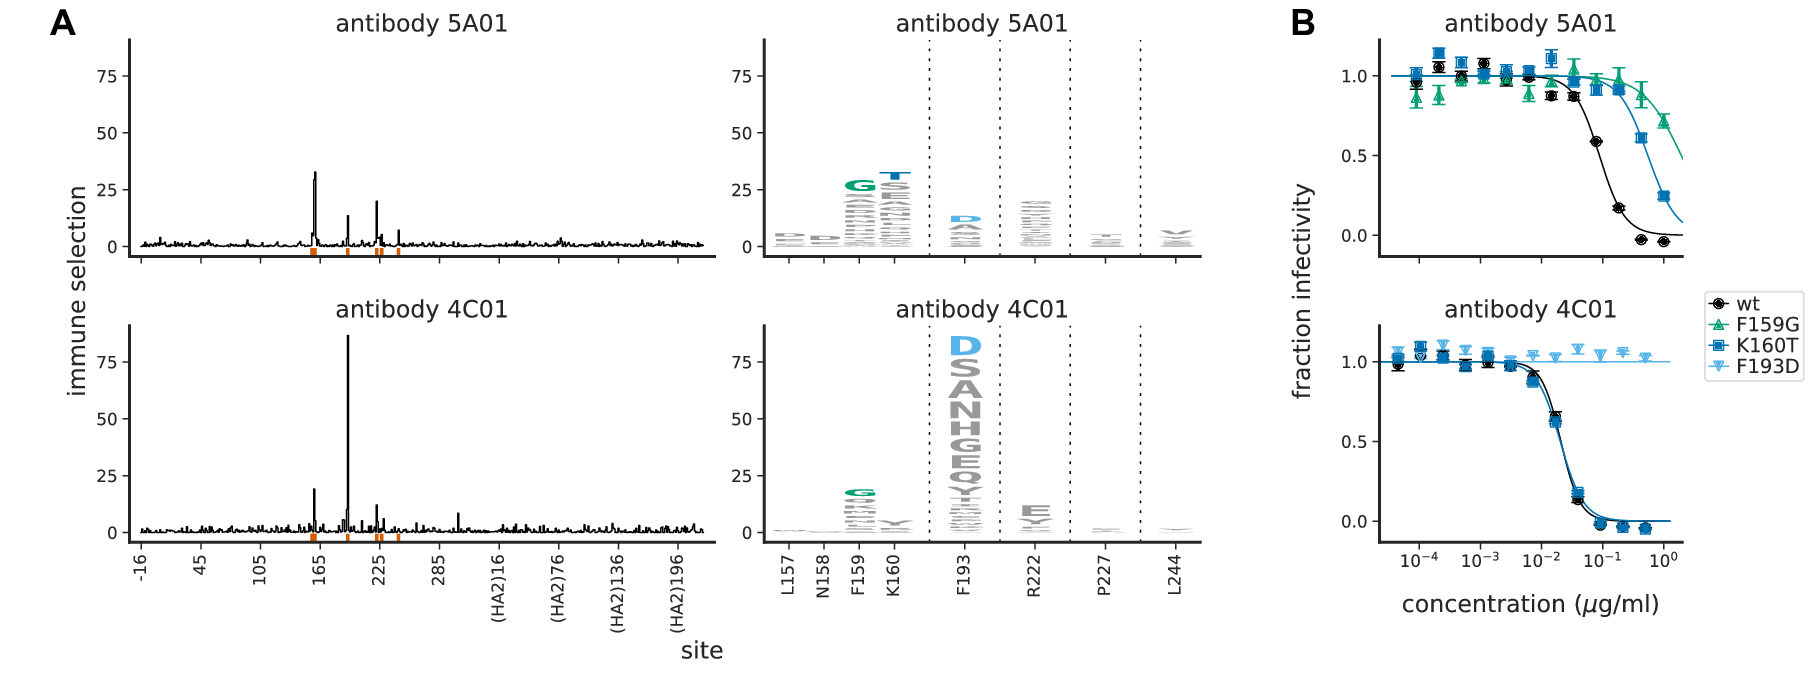


Writing figure to results/figures/antibody_spikein_logo_and_neut.svg and results/figures/antibody_spikein_logo_and_neut.pdf


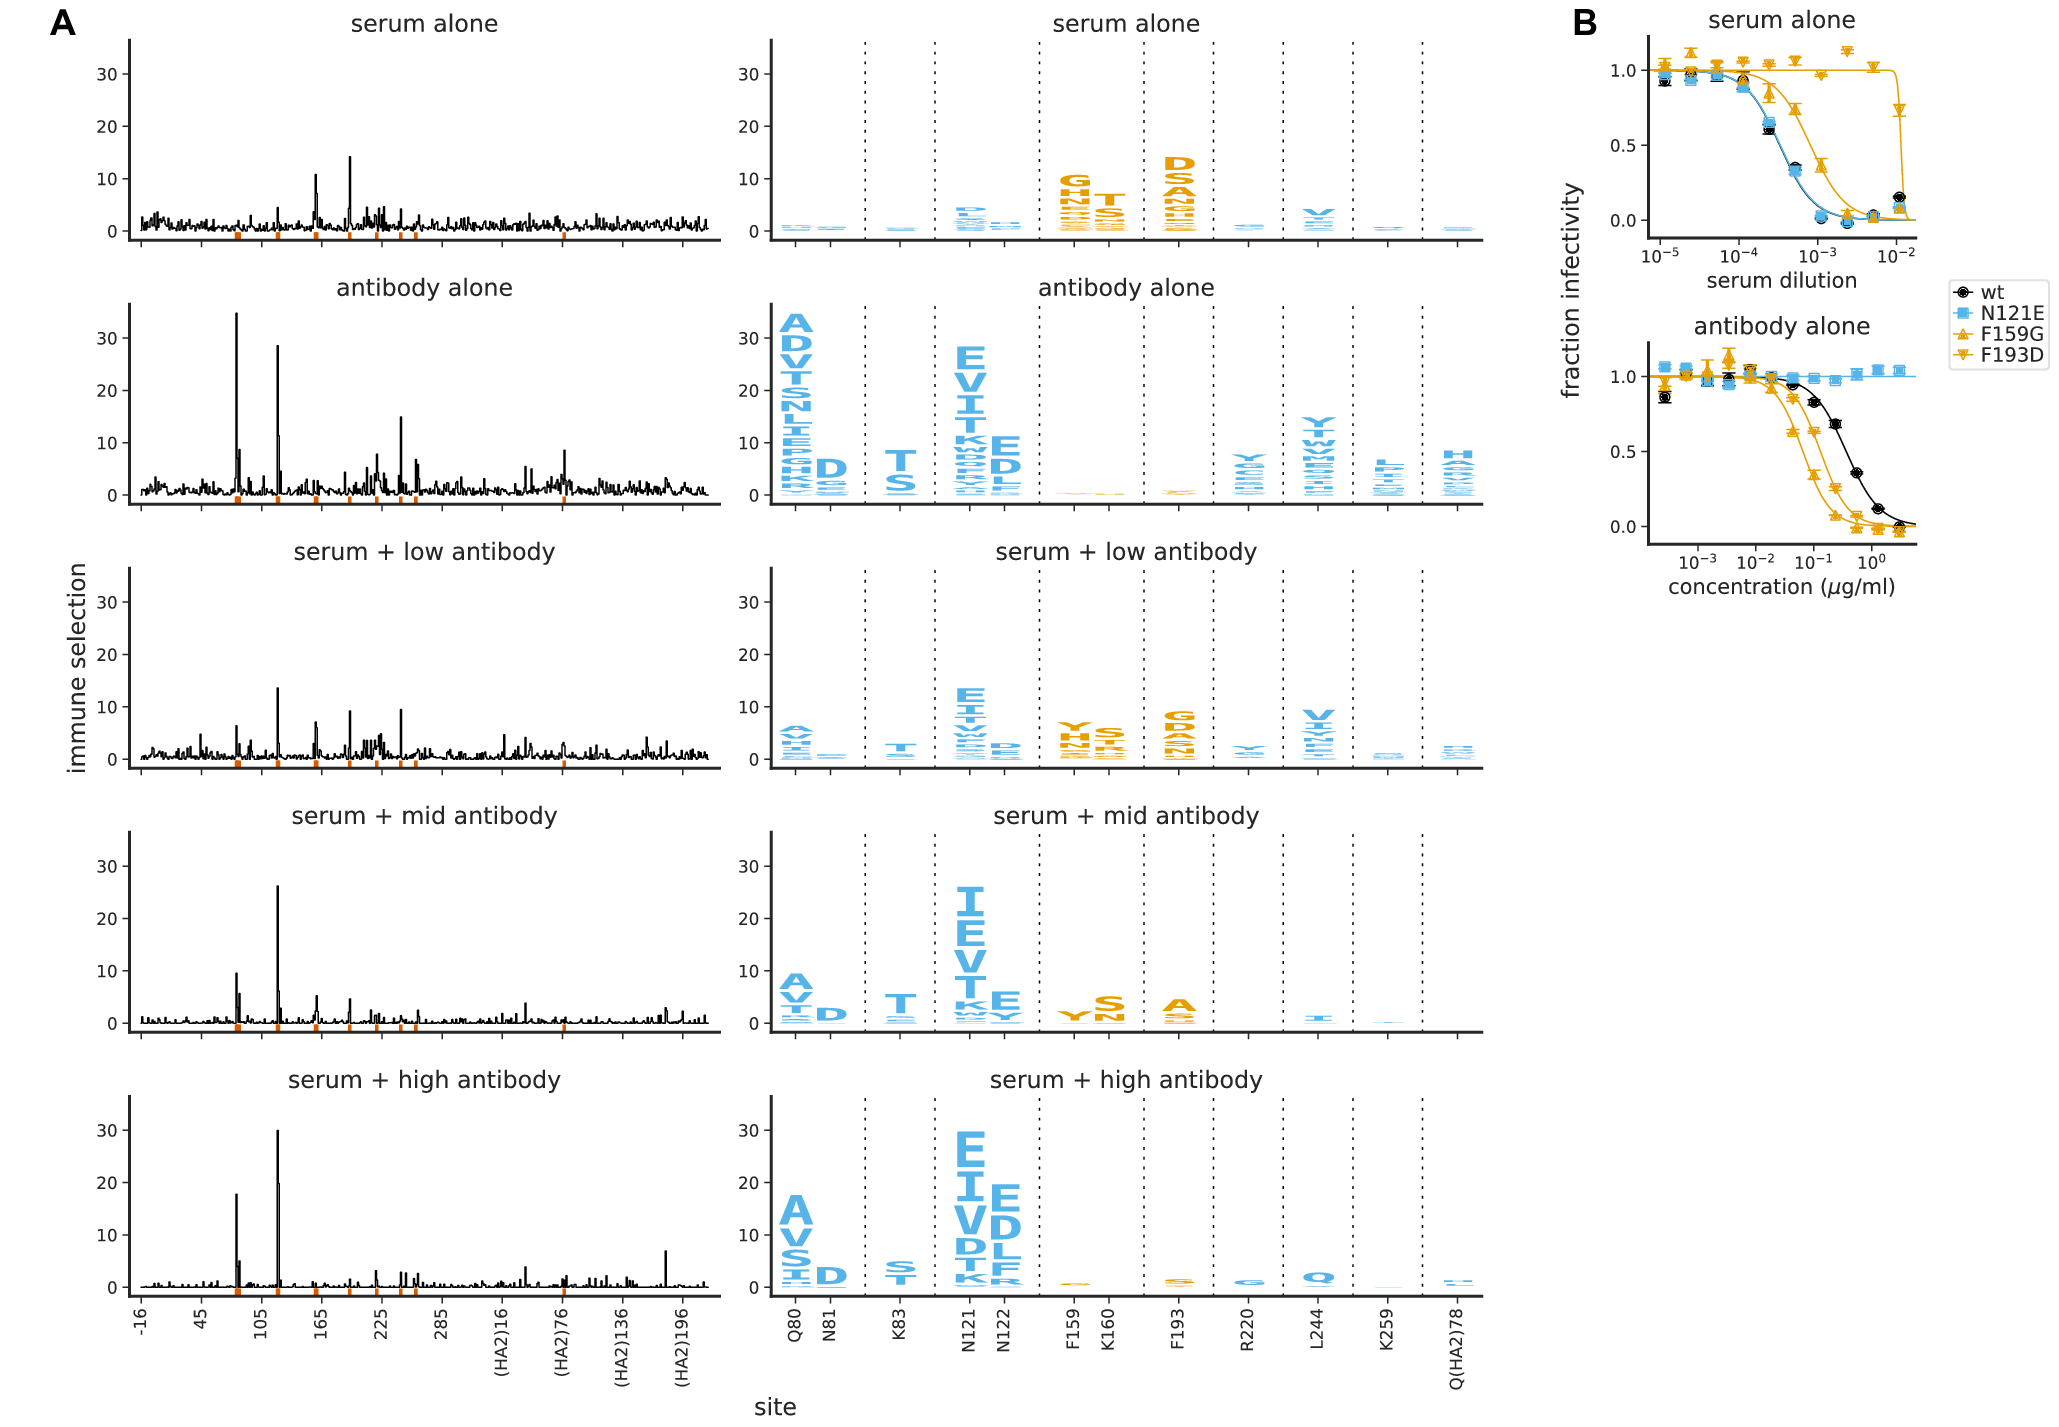


Writing figure to results/figures/ferret_logo_and_neut.svg and results/figures/ferret_logo_and_neut.pdf


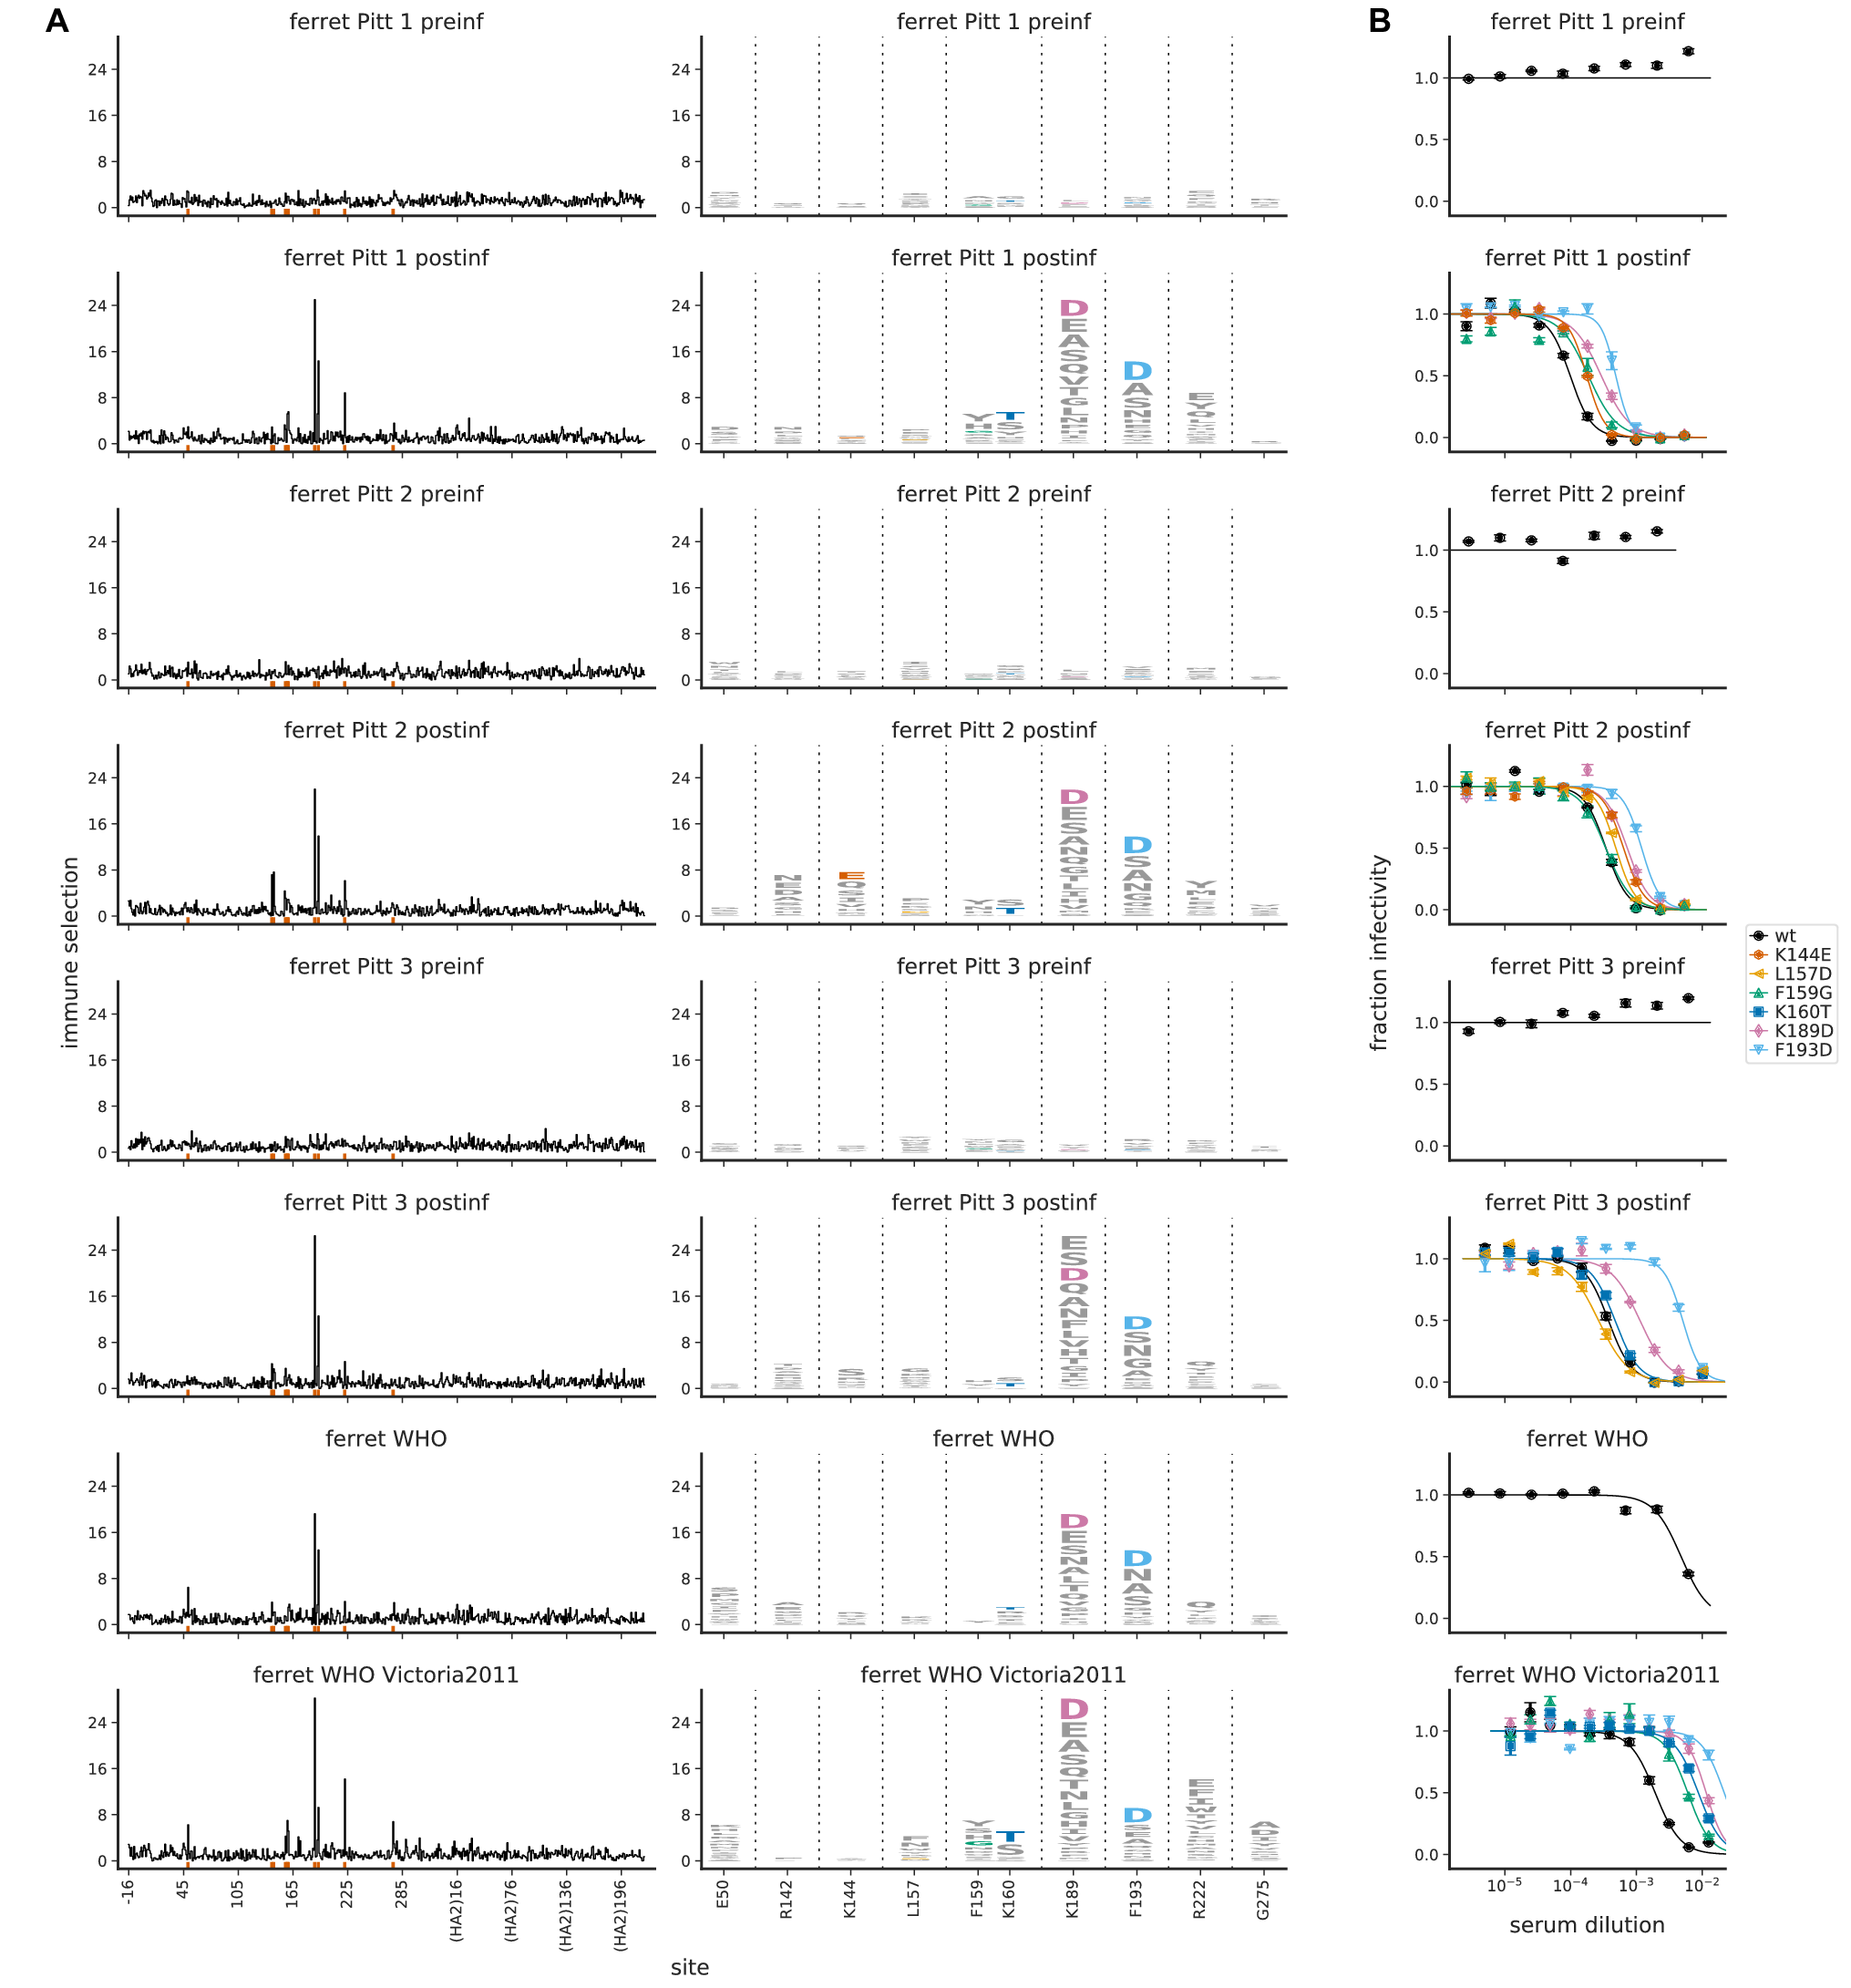

In [20]:
for neutsvgfile in neutsvgfiles:
    logosvgfile = neutsvgfile.replace('_neut', '_logo')
    assert os.path.isfile(logosvgfile), f"cannot find {logosvgfile}"
    svgfile = neutsvgfile.replace('_neut', '_logo_and_neut')
    plots = [logosvgfile, neutsvgfile]
    widths = [svg_dim(p, 'width') for p in plots]
    heights = [svg_dim(p, 'height') for p in plots]
    xshifts = numpy.cumsum(widths) - numpy.array(widths)
    xshifts = numpy.clip(xshifts - 1, 0, None)  # reduce by one to avoid gaps
    figure = os.path.basename(neutsvgfile).replace('_neut.svg', '')
    letters = [figure_config['figures'][figure]['logo_panel_label'],
               figure_config['figures'][figure]['neut_panel_label']]
    fig_elements = []
    for letter, p, x in zip(letters, plots, xshifts):
        fig_elements.append(svgutils.compose.SVG(p).move(x, 0))
        fig_elements.append(svgutils.compose.Text(letter, 15, 25, weight='bold',
                                                  size='26', font='Arial').move(x, 0))
    f = svgutils.compose.Figure(sum(widths), max(heights), *fig_elements)
    f.save(svgfile)
    pdffile = svg_to_pdf(svgfile)
    print(f"\nWriting figure to {svgfile} and {pdffile}")
    showPDF(pdffile)

Now tabulate the fit parameters for the serum / viruses that we plotted in the figures:

In [21]:
fit_table = (
    fits.fitParams()
    .query('replicate == "average"')
    .merge(pd.DataFrame.from_records(sera_viruses_plotted, columns=['serum', 'virus']),
           how='inner')
    [['serum', 'virus', 'ic50_str', 'slope', 'top', 'bottom']]
    .drop_duplicates()
    .sort_values(['serum', 'virus'], ascending=[True, False])
    )

display(HTML(fit_table.to_html(index=False)))

fit_table_file = os.path.join(outdir, 'neut_assay_figs_fit_params.csv')
print(f"Writing table to {fit_table_file}")
fit_table.to_csv(fit_table_file, index=False, float_format='%.3g')

serum,virus,ic50_str,slope,top,bottom
2009-age-53,wt,0.00124,1.779854,1,0
2009-age-53,syn,0.00153,2.317304,1,0
2009-age-53,L157D,0.00481,1.976588,1,0
2009-age-53,K189D,0.000548,1.858524,1,0
2009-age-53,K160T,0.00338,2.118445,1,0
2009-age-53,F193D,0.00234,1.856293,1,0
2009-age-53,F159G,0.00122,1.937588,1,0
2009-age-53-plus-2-months,wt,0.00172,1.208408,1,0
2009-age-53-plus-2-months,L157D,0.00931,2.644218,1,0
2009-age-53-plus-2-months,K160T,0.00387,2.206105,1,0


Writing table to results/neutralization_assays/neut_assay_figs_fit_params.csv
